In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pwd

/content


In [0]:
import os

In [0]:
os.chdir('/content/sample_data')

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
figsize=(15, 6)
plt.style.use('fivethirtyeight')

In [8]:
# Fashion-MNIST data loader
train_dataset = dsets.FashionMNIST(root='./data',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='./data',
                                  train=False,
                                  transform=transforms.ToTensor())

  0%|          | 131072/26421880 [00:00<00:20, 1310524.40it/s]

26427392it [00:00, 84153474.36it/s]                             


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


32768it [00:00, 615862.49it/s]
 20%|█▉        | 876544/4422102 [00:00<00:00, 8403237.43it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


4423680it [00:00, 31351397.59it/s]                           
8192it [00:00, 116100.20it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw
Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [0]:
# Batch size, iterations and epochs
batch_size = 100
n_iters = 15000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Label 9


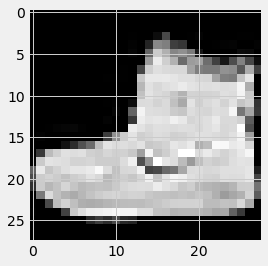

In [28]:
# Sample 0: boot
sample_num = 0
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

Label 0


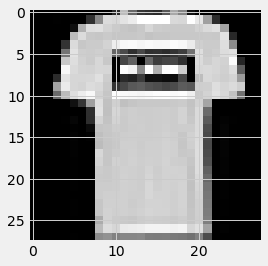

In [29]:
# Sample 1: shirt
sample_num = 1
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

Label 3


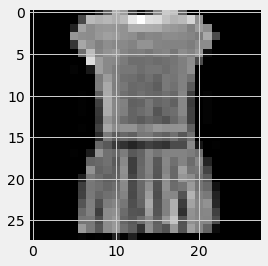

In [30]:
# Sample 3: dress
sample_num = 3
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

In [31]:
min_pixel_value = train_dataset[sample_num][0].min()
max_pixel_value = train_dataset[sample_num][0].max()

print(f'Minimum pixel value: {min_pixel_value}')
print(f'Maximum pixel value: {max_pixel_value}')

Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [0]:
# Model definition
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Decoder: affine function
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Encoder: affine function
        out = self.fc1(x)
        # Encoder: non-linear function
        out = F.leaky_relu(out)

        # Decoder: affine function
        out = self.fc2(out)
        # Decoder: non-linear function
        out = torch.sigmoid(out)

        return out

In [0]:
# Dimensions for overcomplete (larger latent representation)
input_dim = 28*28
hidden_dim = int(input_dim * 1.5)
output_dim = input_dim

# Instantiate Fully-connected Autoencoder (FC-AE)
# And assign to model object
model = FullyConnectedAutoencoder(input_dim, hidden_dim, output_dim)

In [0]:
# We want to minimize the per pixel reconstruction loss
# So we've to use the mean squared error (MSE) loss
# This is similar to our regression tasks' loss
criterion = nn.MSELoss()

In [0]:
# Using basic Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [35]:
# Parameter inspection
num_params_group = len(list(model.parameters()))
for group_idx in range(num_params_group):
    print(list(model.parameters())[group_idx].size())

torch.Size([1176, 784])
torch.Size([1176])
torch.Size([784, 1176])
torch.Size([784])


In [36]:
idx = 0

# Dropout for creating noisy images
# by dropping out pixel with a 50% probability
dropout = nn.Dropout(0.5)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Noisy images
        noisy_images = dropout(torch.ones(images.shape)) * images

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = model(noisy_images)

        # Calculate Loss: MSE Loss based on pixel-to-pixel comparison
        loss = criterion(outputs, images)

        # Getting gradients w.r.t. parameters via backpropagation
        loss.backward()

        # Updating parameters via gradient descent
        optimizer.step()

        idx += 1

        if idx % 500 == 0:
            # Calculate MSE Test Loss
            total_test_loss = 0
            total_samples = 0

            # Iterate through test dataset
            for images, labels in test_loader:
                # Noisy images
                noisy_images = dropout(torch.ones(images.shape)) * images

                # Forward pass only to get logits/output
                outputs = model(noisy_images.view(-1, 28*28))

                # Test loss
                test_loss = criterion(outputs, images.view(-1, 28*28))

                # Total number of labels
                total_samples += labels.size(0)

                # Total test loss
                total_test_loss += test_loss

            mean_test_loss = total_test_loss / total_samples

            # Print Loss
            print(f'Iteration: {idx}. Average Test Loss: {mean_test_loss.item()}.')

Iteration: 500. Average Test Loss: 0.00016121419321279973.
Iteration: 1000. Average Test Loss: 0.000139392854180187.
Iteration: 1500. Average Test Loss: 0.0001343157928204164.
Iteration: 2000. Average Test Loss: 0.00012427647016011178.
Iteration: 2500. Average Test Loss: 0.00012320165114942938.
Iteration: 3000. Average Test Loss: 0.00011917087977053598.
Iteration: 3500. Average Test Loss: 0.00011586597975110635.
Iteration: 4000. Average Test Loss: 0.00011462692054919899.
Iteration: 4500. Average Test Loss: 0.00011385980906197801.
Iteration: 5000. Average Test Loss: 0.00011179380089743063.
Iteration: 5500. Average Test Loss: 0.00011125623859697953.
Iteration: 6000. Average Test Loss: 0.00010979744547512382.
Iteration: 6500. Average Test Loss: 0.00010936623584711924.
Iteration: 7000. Average Test Loss: 0.00010905769158853218.
Iteration: 7500. Average Test Loss: 0.00011070996697526425.
Iteration: 8000. Average Test Loss: 0.0001082516901078634.
Iteration: 8500. Average Test Loss: 0.0001077

Label 4


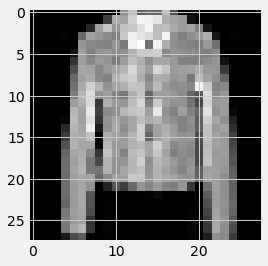

In [37]:
# Test sample: Raw
sample_num = 10
raw_img = test_dataset[sample_num][0]
show_img = raw_img.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

Label 4


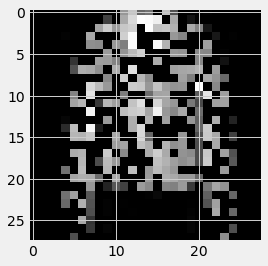

In [21]:
# Test sample: Noisy
sample_num = 10
raw_img = test_dataset[sample_num][0]
noisy_image = dropout(torch.ones(raw_img.shape)) * raw_img
show_img = noisy_image.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

Label 4


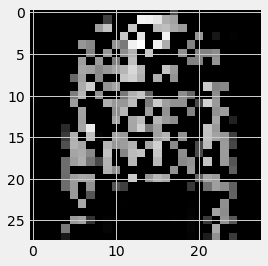

In [38]:
# Test sample: Noisy
sample_num = 10
raw_img = test_dataset[sample_num][0]
noisy_image = dropout(torch.ones(raw_img.shape)) * raw_img
show_img = noisy_image.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');